# Project on Stroke Prediction

## Machine Learning Workflow

Although the exact implementation details can vary, the general structure of a machine learning project stays relatively constant:

    1) Data cleaning and formatting
    2) Exploratory data analysis
    3) Feature engineering and selection
    4) Establish a baseline and compare several machine learning models on a performance metric
    5) Perform hyperparameter tuning on the best model to optimize it for the problem
    6) Evaluate the best model on the testing set
    7) Interpret the model results to the extent possible
    8) Draw conclusions and write a well-documented report

# Import
We will use the standard data science and machine learning libraries: numpy, pandas, and scikit-learn. We also use matplotlib and seaborn for visualization.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice, i.e. no annoying pink boxes
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

# Data Cleaning and Formatting

## Load in the Data and Examine

We will be loading our data into a pandas dataframe, one of the most useful data structures for data science. Think of it as a spreadsheet within Python that we can easily manipulate, clean, and visualize. [Pandas has many methods](http://pandas.pydata.org/pandas-docs/stable/) to help make the data science/machine learning pipeline as smooth as possible.

In [2]:
# Read in data into a dataframe 
train_df = pd.read_csv('train_2v.csv')
test_df = pd.read_csv('test_2v.csv')

# Because data is huge, for purpose of practice, will reduce it to 20% sample of the whole population for the time being.
train_df = train_df.sample(frac=0.6, replace=True)

# Display top of dataframe
train_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
41996,1810,Female,43.0,0,0,Yes,Private,Urban,96.88,24.6,formerly smoked,0
4007,24262,Female,31.0,0,0,Yes,Private,Rural,70.91,28.3,never smoked,0
33260,21315,Female,66.0,0,0,Yes,Private,Rural,82.92,24.6,never smoked,0
31743,22050,Female,42.0,0,0,Yes,Self-employed,Urban,204.93,26.6,smokes,0
20355,70650,Female,74.0,1,0,No,Private,Rural,77.73,21.7,never smoked,0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26040 entries, 41996 to 39038
Data columns (total 12 columns):
id                   26040 non-null int64
gender               26040 non-null object
age                  26040 non-null float64
hypertension         26040 non-null int64
heart_disease        26040 non-null int64
ever_married         26040 non-null object
work_type            26040 non-null object
Residence_type       26040 non-null object
avg_glucose_level    26040 non-null float64
bmi                  25141 non-null float64
smoking_status       18032 non-null object
stroke               26040 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 2.6+ MB


Let's take a look to see if there are missing data in this dataframe set for Stroke

In [4]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
missing_values_table(train_df)

Your selected dataframe has 12 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
smoking_status,8008,30.8
bmi,899,3.5


# Exploratory Data Analysis

In [6]:
train_df_stroke = train_df.loc[train_df['stroke'] == 1]
sns.set(style="ticks")

In [7]:
numerical = [
  'age', 'bmi', 'avg_glucose_level'
]
categorical = [
  'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
]

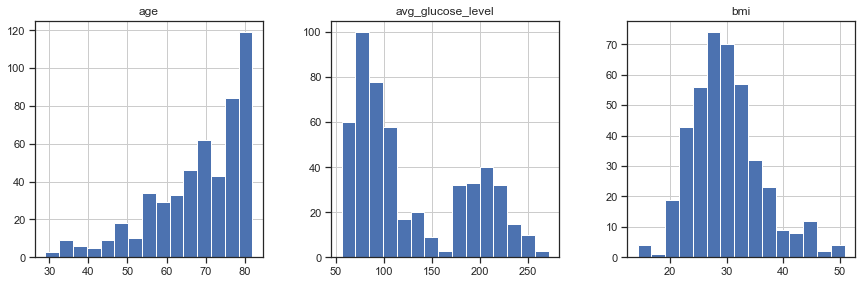

In [8]:
train_df_stroke[numerical].hist(bins=15, figsize=(20, 10), layout=(2, 4));

For the numerical data columns theres a few deductions can make by looking at the counts.
1. Chances of stroke is higher for people reaching the age of late 70s to their 80s.
2. Number of people with stroke is higher for those who seem to have average glucose level that is within the [permitted range](https://www.webmd.com/diabetes/qa/what-are-normal-blood-sugar-levels). 
3. Those whose BMI were at the higher end of 20s seem to be more susceptible to getting stroke.

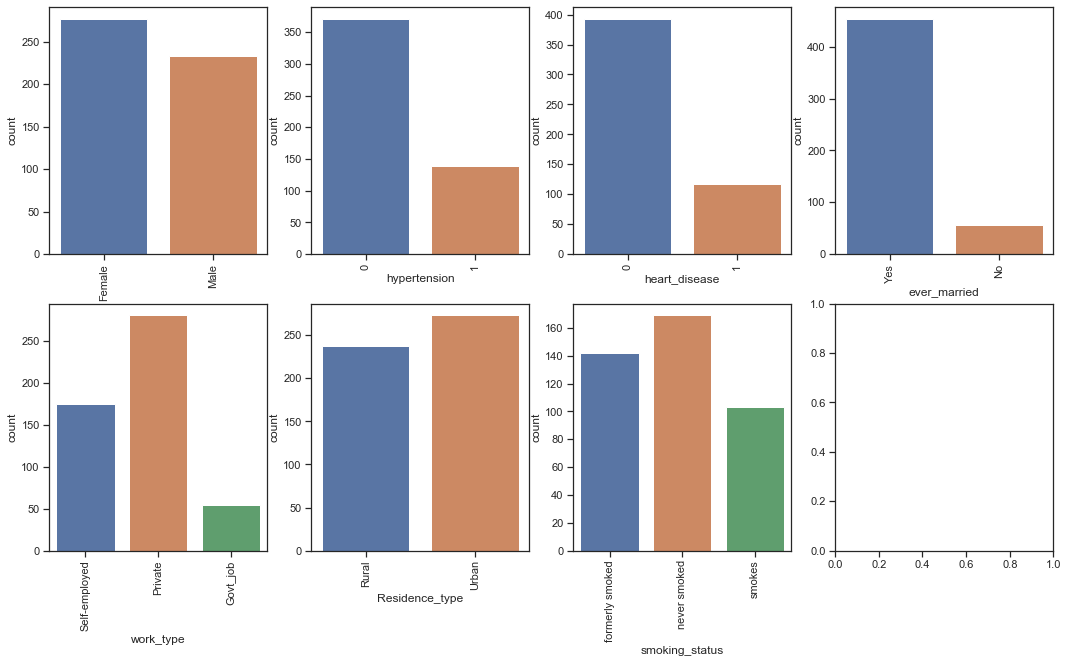

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(18, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(train_df_stroke[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

If we look at the count of victims with stroke for each feature, the likely stroke victim seems to be one who is Female, Urban, Private, never smoke, married. Each of this feature seems to have an impact on the prediction one whether the person may have stroke. Some deductions like not smoking goes against some of our assumptions. One would have thought that smoking would likely lead you to have stroke in comparison to a non-smoker. So lets take a look at each of them further. We begin by doing a quantitative and categorical summary anaysis for the features.

In [10]:
def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()

In [11]:
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()


In [12]:
c_palette = ['tab:blue', 'tab:orange']

count    510.000000
mean      68.266667
std       11.846740
min       29.000000
25%       61.000000
50%       70.500000
75%       78.000000
max       82.000000
Name: age, dtype: float64
mode:  0    79.0
dtype: float64


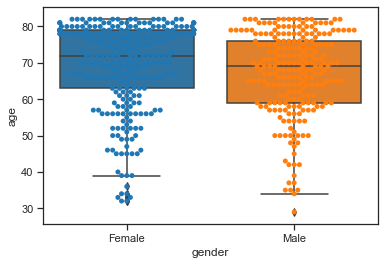

In [13]:
#Bivariate Analysis with target variable
quantitative_summarized(dataframe= train_df_stroke, y = 'age', x = 'gender', palette=c_palette, verbose=False, swarm=True)

From the data we can see that the average age of people with stroke seem to be in their late 60s to 70s for both Males & Females. Females were likely to be a stroke victim at an older age among the 2 genders. It seems to me that gender may play a part in predicting stroke. Lets now take a look at smoking status of our data set. I'll be setting the hue to include gender to see if we can see any insights and relationship between gender and smoking status for our stroke victims.

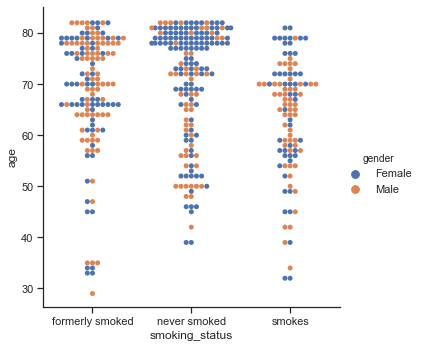

In [14]:
sns.catplot(x="smoking_status", y="age", hue="gender", kind="swarm", data=train_df_stroke);

Based on the graph we can agree that our assumptions still hold that smoking does have an impact on stroke, in particular age. We can see that for the smoke category, age seems to have a wider spread. We can deduce that smoking does result in people getting stroke at a younger age in comparison to those that never smoke or formerly smoked. Lets take a look further at hypertension and age as a factor of stroke. We will carry out a multivariate analysis below on these variable factors. 

count    510.000000
mean      68.266667
std       11.846740
min       29.000000
25%       61.000000
50%       70.500000
75%       78.000000
max       82.000000
Name: age, dtype: float64
mode:  0    79.0
dtype: float64


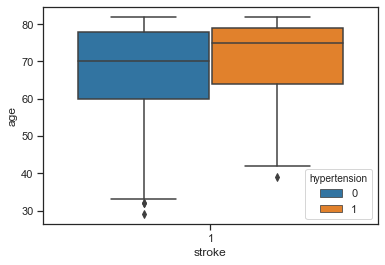

In [15]:
# multivariate analysis with Embarked variable and Pclass variable
quantitative_summarized(dataframe= train_df_stroke, y = 'age', x = 'stroke', hue = 'hypertension', palette=c_palette, verbose=False, swarm=False)


Surprisingly stroke victims were more likely to be older if they actually had hypertension. This may actually seem counter intuitive but I believe this could be due to the fact that people who have hypertension were more likely to be on medication to control their blood pressure. This could possible be a factor that helped those with hypertension to prolong their health before falling to stroke at a later age.

I also decided to create a jointplot between bmi & age for stroke data to see if they have any related relationship. From the jointplot below, we can see that there is no clear cut linear relationship. Nevertheless there is a possibility that BMI & age can help us predict if one were to have stroke.

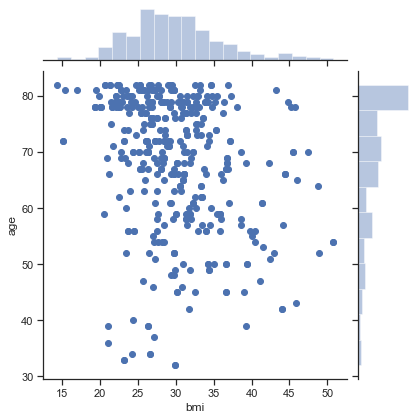

In [16]:
sns.jointplot(x=train_df_stroke['bmi'], y=train_df_stroke['age']);

# Feature Engineering & Selection

## One Hot Encoding for Categorical Variables

In [17]:
# PENDING CODE FOR ONE HOT ENCODING

# Select the numeric columns
numeric_subset = train_df.select_dtypes('number')

# Create columns with log of numeric columns
for col in numeric_subset.columns:
    # Skip the target column
    if col == 'stroke':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
# Select the categorical columns
categorical_subset = train_df[['gender','ever_married','work_type','Residence_type','smoking_status']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
train_df = pd.concat([numeric_subset, categorical_subset], axis = 1)

train_df.shape

C:\Users\Ismahfaris\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(26040, 28)


## Remove Collinear Features

Since I mentioned about linear relationships, I think its good to highlight that highly [collinear features](http://psychologicalstatistics.blogspot.com/2013/11/multicollinearity-and-collinearity-in.html) have a significant correlation coefficent between them. Thus, to opmitimize our models, we should look to remove any of the collinear features. 

In [18]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Score
    y = x['stroke']
    x = x.drop(columns = ['stroke'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    
    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)

    
    # Add the score back in to the data
    x['stroke'] = y
               
    return x

In [19]:
# Remove the collinear features above a specified correlation coefficient
train_df = remove_collinear_features(train_df, 0.6);

C:\Users\Ismahfaris\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal


In [20]:
# Remove any columns with all na values
train_df  = train_df.dropna(axis=1, how = 'all')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26040 entries, 41996 to 39038
Data columns (total 21 columns):
id                                26040 non-null int64
age                               26040 non-null float64
hypertension                      26040 non-null int64
heart_disease                     26040 non-null int64
avg_glucose_level                 26040 non-null float64
bmi                               25141 non-null float64
log_hypertension                  26040 non-null float64
log_heart_disease                 26040 non-null float64
gender_Female                     26040 non-null uint8
gender_Male                       26040 non-null uint8
gender_Other                      26040 non-null uint8
work_type_Govt_job                26040 non-null uint8
work_type_Never_worked            26040 non-null uint8
work_type_Private                 26040 non-null uint8
work_type_Self-employed           26040 non-null uint8
Residence_type_Rural              26040 non-null uin

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26040 entries, 41996 to 39038
Data columns (total 21 columns):
id                                26040 non-null int64
age                               26040 non-null float64
hypertension                      26040 non-null int64
heart_disease                     26040 non-null int64
avg_glucose_level                 26040 non-null float64
bmi                               25141 non-null float64
log_hypertension                  26040 non-null float64
log_heart_disease                 26040 non-null float64
gender_Female                     26040 non-null uint8
gender_Male                       26040 non-null uint8
gender_Other                      26040 non-null uint8
work_type_Govt_job                26040 non-null uint8
work_type_Never_worked            26040 non-null uint8
work_type_Private                 26040 non-null uint8
work_type_Self-employed           26040 non-null uint8
Residence_type_Rural              26040 non-null uin

## Split into Training & Test Set

In [22]:
# Extract the buildings with no score and the buildings with a score
no_score = train_df[train_df['stroke'].isna()]
score = train_df[train_df['stroke'].notnull()]

print(no_score.shape)
print(score.shape)

(0, 21)
(26040, 21)


In [23]:
# Separate out the features and targets
features = score.drop(columns='stroke')
targets = pd.DataFrame(score['stroke'])

# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.5, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(13020, 20)
(13020, 20)
(13020, 1)
(13020, 1)


# Machine Learning Modeling

Once feature engineering/construction is done, we can get started with the machine learning! All of our data (both training and testing) is aggregated for each household and so can be directly used in a model. To first show the process of modeling, we'll use the capable Random Forest Classifier in Scikit-Learn. This probably won't get us to the top of the leaderboard, but it will allow us to establish a baseline. Later we'll try several other models including the powerful Gradient Boosting Machine.

To assess our model, we'll use 10-fold cross validation on the training data. This will essentially _train and test the model 10 times_ using different splits of the training data. 10-fold cross validation is an effective method for estimating the performance of a model on the test set. We want to look at the average performance in cross validation as well as the standard deviation to see how much scores change between the folds. We use the `F1 Macro` measure to evaluate performance.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [25]:
# Save the no scores
#no_score.to_csv('data/no_score.csv', index = False)

#Give training, and testing data more recognizable names
train_features = X
test_features = X_test
train_labels = y
test_labels = y_test

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (13020, 20)
Testing Feature Size:   (13020, 20)
Training Labels Size:   (13020, 1)
Testing Labels Size:    (13020, 1)


In [26]:
features = list(train_features.columns)

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_features = pipeline.fit_transform(train_features)
test_features = pipeline.transform(test_features)

C:\Users\Ismahfaris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [27]:
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, train_features, train_labels.values.ravel(), cv = 10, scoring = scorer)

print(f'10 Fold Cross Validation Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation Score = 0.7017 with std = 0.051


In [28]:
model.fit(train_features, train_labels.values.ravel())

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

,feature,importance
0,id,0.217664
1,age,0.174755
2,hypertension,0.017731
3,heart_disease,0.021499
4,avg_glucose_level,0.229856


In [29]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

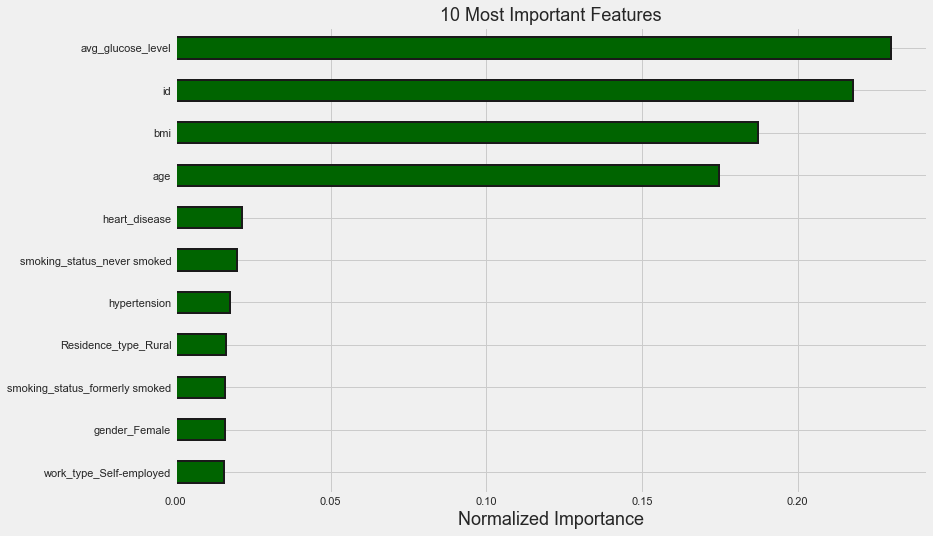

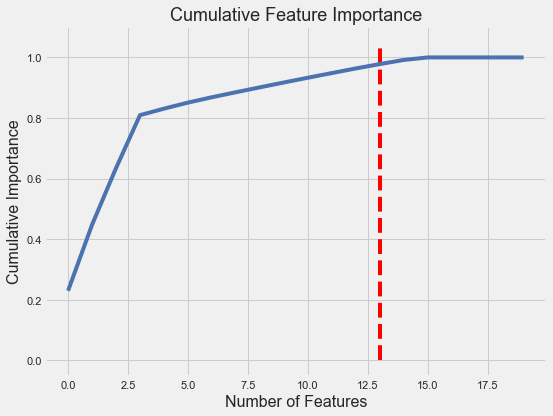

13 features required for 95% of cumulative importance.


In [30]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

In [31]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [32]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels.values.ravel(), cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [33]:
model_results = cv_model(train_features, train_labels, LinearSVC(), 
                         'LSVC', model_results)

10 Fold CV Score: 0.49478 with std: 6e-05


In [34]:
model_results = cv_model(train_features, train_labels, 
                         GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.13013 with std: 0.01177


In [35]:
model_results = cv_model(train_features, train_labels, 
                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
                         'MLP', model_results)

10 Fold CV Score: 0.63268 with std: 0.03262


In [36]:
model_results = cv_model(train_features, train_labels, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)

10 Fold CV Score: 0.52675 with std: 0.02936


In [37]:
model_results = cv_model(train_features, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.49478 with std: 6e-05


In [38]:
for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_features, train_labels, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)


KNN with 5 neighbors

10 Fold CV Score: 0.50065 with std: 0.01302

KNN with 10 neighbors

10 Fold CV Score: 0.49478 with std: 6e-05

KNN with 20 neighbors

10 Fold CV Score: 0.49478 with std: 6e-05


In [39]:
from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_features, train_labels, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)

10 Fold CV Score: 0.69321 with std: 0.05317


## Comparing Model Performance

In [40]:
model_results = cv_model(train_features, train_labels,
                          RandomForestClassifier(100, random_state=10),
                              'RF', model_results)

10 Fold CV Score: 0.70171 with std: 0.05105


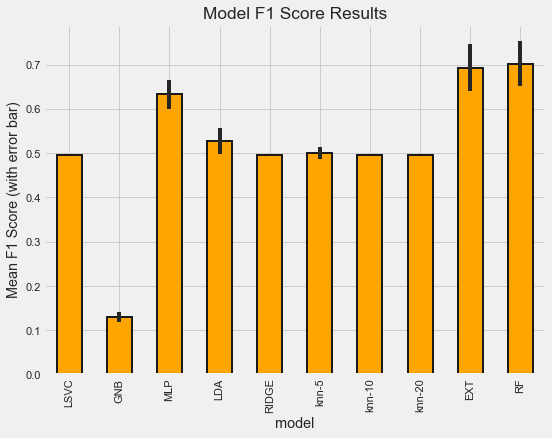

In [41]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                  edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

# Upgrading Our Model: Gradient Boosting Machine


### Choosing Number of Estimators with Early Stopping

To choose the number of estimators (the number of decision trees in the ensemble, called `n_estimators` or `num_boost_rounds`), we'll use early stopping with 5-fold cross validation. This will keep adding estimators until the performance as measured by the Macro F1 Score has not increased for 100 training rounds. To use this metric, we'll have to define a custom metric.

In [42]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

# Light Gradient Boosting Machine Implementation

The function below implements training the gradient boosting machine with Stratified Kfold cross validation and early stopping to prevent overfitting to the training data (although this can still occur). The function performs training with cross validation and records the predictions in probability for each fold. To see how this works, we can return the predictions from each fold and then we'll return a submission to upload to the competition.

Choosing hyperparameters for the Gradient Boosting Machine can be tough and generally is done through model optimization. In this notebook, we'll use a set of hyperparameters that I've found work well on previous problems (although they will not necessarily translate to this competition). 

We set the `n_estimators` to 10000 but we won't actually reach this number because we are using early stopping which will quit training estimators when the cross validation metric does not improve for `early_stopping_rounds`. There's a lot going on in this function, and read through it carefully to make sure you have it all! I've tried to make the comments and code straightforward. (The `display` is used to show custom information during training in combination with `%%capture` so we don't have to see all the LightGBM information during training).

In [43]:
import sys
#!{sys.executable} -m pip install lightgbm

In [51]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, 
              nfolds = 5, return_preds = False, hyp = None):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features)

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of estimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028,
                  'num_class':3,
                   'min_child_samples': 10, 
                   'num_leaves': 36, 'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}
    
    # Build the model
    model = lgb.LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        fold_predictions['id'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['stroke'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        #predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('id', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # return the submission and feature importances along with validation scores
    return  feature_importances, valid_scores

### Cross Validation with Early Stopping Notes

Cross validation with early stopping is one of the most effective methods for preventing overfitting on the training set because it prevents us from continuing to add model complexity once it is clear that validation scores are not improving. Repeating this process across multiple folds helps to reduce the bias that comes from using a single fold. Early stopping also lets us train the model much quicker. Overall, __early stopping with cross validation__ is the best method to select the number of estimators in the Gradient Boosting Machine and should be our default technique when we desig an implementation.

In [52]:
%%capture --no-display
predictions, gbm_fi = model_gbm(train_features, train_labels, test_features, return_preds=True)

ValueError: cannot reshape array of size 31245 into shape (2,newaxis)

The power of the Gradient Boosting Machine can be seen here! The cross validation score blows away anything we've done previously. 

Let's take a look at the predictions to understand what is going on with the predictions in each fold.

In [ ]:
predictions.head()

For each fold, the `1, 2, 3, 4` columns represent the probability for each `Target`. The `Target` is the maximum of these with the `confidence` the probability. We have the predictions for all 5 folds, so we can plot the confidence in each `Target` for the different folds.

In [ ]:
plt.rcParams['font.size'] = 18

# Kdeplot
g = sns.FacetGrid(predictions, row = 'fold', hue = 'Target', size = 3, aspect = 4)
g.map(sns.kdeplot, 'confidence');
g.add_legend();

plt.suptitle('Distribution of Confidence by Fold and Target', y = 1.05);

What we see here is that the confidence for each class if relatively low. It does appear that the model has greater confidence in `Target=4` predictions which makes sense because of the _class imbalance and the high prevalence of this label._ 

Another way to look at the information is as a `violinplot`. This shows the same information, with the number of observations related to the width of the plot.

In [ ]:
plt.figure(figsize = (24, 12))
sns.violinplot(x = 'Target', y = 'confidence', hue = 'fold', data = predictions);

Overall, these results show the issue with imbalanced class problems: our model cannot distinguish very well between the classes that are underrepresented. Later we'll look at predictions themselves and see where our model is "confused". For now, we can generate a submission file and submit it to the competition.

When we actually make predictions for each household, we average the predictions from each of the folds. Therefore, we are essentially using multiple models since each one is trained on a slightly different fold of the data. The gradient boosting machine is already an ensemble machine learning model, and now we are using it almost as a meta-ensemble by averaging predictions from several gbms. 

This process is shown in the code below.

In [ ]:
# Average the predictions over folds
predictions = predictions.groupby('idhogar', as_index = False).mean()

# Find the class and associated probability
predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
predictions = predictions.drop(columns = ['fold'])

# Plot the confidence by each target
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'confidence', data = predictions);
plt.title('Confidence by Target');

plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'confidence', data = predictions);
plt.title('Confidence by Target');

We can have the function instead return the actual submission file. This takes the average predictions across the five folds, in effectm combining 5 different models, each one trained on a slghtly different subset of the data.

In [ ]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_set, train_labels, 
                                             test_set, test_ids, return_preds=False)

submission.to_csv('gbm_baseline.csv')

In [ ]:
_ = plot_feature_importances(gbm_fi, threshold=0.95)